In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from SALib.analyze import dgsm, sobol, delta
from SALib.sample import finite_diff, saltelli
from SALib.util import read_param_file

In [2]:
# Файлы уже с данными только по России
b_history = pd.read_csv('edited_data/b_history.csv', sep=';', index_col='Year')
m_history = pd.read_csv('edited_data/m_history.csv', sep=';', index_col='Year')
f_history = pd.read_csv('edited_data/f_history.csv', sep=';', index_col='Year')
b_future = pd.read_csv('edited_data/b_future.csv', sep=';', index_col='Year')
m_future = pd.read_csv('edited_data/m_future.csv', sep=';', index_col='Year')
f_future = pd.read_csv('edited_data/f_future.csv', sep=';', index_col='Year')

In [3]:
# Предварительная подготовка данных
m_history_update = {year: [year, value] for year, value in zip(m_history.index[:-3], m_history['75 - 79'])}
f_history_update = {year: [year, value] for year, value in zip(f_history.index[:-3], f_history['75 - 79'])}
b_history_update = {year: [year, m_value + f_value, 0, 0, 0, 0, 0] for year, m_value, f_value in 
                    zip(m_history.index[:-3], m_history['75 - 79'], f_history['75 - 79'])}

for update_history, history in zip((m_history_update, f_history_update), (m_history, f_history)):

    probas = history.shift(-1).shift(-1, axis="columns").div(history). \
                     loc[2000][[str(i) + ' - ' + str(i + 4) for i in range(75, 96, 5)]]
    update_history[1950] = [1950, history.loc[1950]['75 - 79'], None, None, None, None, None]

    for year, prev_year in zip(list(update_history.keys())[1:], update_history.keys()):
        for i, proba in enumerate(probas):
            update_history[year].append(update_history[prev_year][i + 1] * proba) if update_history[prev_year][i + 1] \
                                 else update_history[year].append(None)
    
    for year, values in update_history.items():
        for i, value in enumerate(values[2:]):
            if value:
                b_history_update[year][i + 2] += value
            else:
                b_history_update[year][i + 2] = None

m_history_update = pd.DataFrame.from_dict(m_history_update, orient='index', 
                                          columns=['Year'] + [str(i) + ' - ' + str(i + 4) for i in range(75, 96, 5)] + ['100+'])
f_history_update = pd.DataFrame.from_dict(f_history_update, orient='index', 
                                          columns=['Year'] + [str(i) + ' - ' + str(i + 4) for i in range(75, 96, 5)] + ['100+'])
 
b_history_update = pd.DataFrame.from_dict(b_history_update, orient='index', 
                                          columns=['Year'] + [str(i) + ' - ' + str(i + 4) for i in range(75, 96, 5)] + ['100+'])
    
m_history.update(m_history_update)
f_history.update(f_history_update)
b_history.update(b_history_update)

In [4]:
# Функции для подсчита соотношения м/ж, коэффициента фертильности, коэффициента выживаемости,
def sex_ratio(year):
    return m_history.take([0], axis=1).div(b_history.take([0], axis=1)).loc[year, :][0], \
           f_history.take([0], axis=1).div(b_history.take([0], axis=1)).loc[year, :][0]
def fertility(year):
    return b_history.take([0], axis=1).loc[year, :][0] / \
           sum(f_history.loc[year, [col for col in f_history.columns if '19' < col < '40 - 44']].values)
def survival(year):
    return m_history.shift(-1).shift(-1, axis="columns").div(m_history).loc[year, :], \
           f_history.shift(-1).shift(-1, axis="columns").div(f_history).loc[year, :]

In [5]:
m_ratio_history = [sex_ratio(year)[0] for year in b_history.index]
m_ratio_bounds = min(m_ratio_history), max(m_ratio_history)
f_ratio_history = [sex_ratio(year)[1] for year in b_history.index]
f_ratio_bounds = min(f_ratio_history), max(f_ratio_history)

fertility_history = [fertility(year) for year in b_history.index[3:]]
fertility_bounds = min(fertility_history), max(fertility_history)

m_survival_history = {age: [] for age in b_history.columns[:-1]}
f_survival_history = {age: [] for age in b_history.columns[:-1]}
for year in b_history.index[:-1]:
    m_survival = survival(year)[0].dropna()
    f_survival = survival(year)[1].dropna()
    for age in b_history.columns[:-1]:
        if age in m_survival.index:
            m_survival_history[age].append(m_survival[age])
        if age in f_survival.index:
            f_survival_history[age].append(f_survival[age])

m_survival_bounds = {age: (min(values), max(values)) for age, values in m_survival_history.items()}
f_survival_bounds = {age: (min(values), max(values)) for age, values in f_survival_history.items()}

In [6]:
names = ['fertility', 'm_ratio'] + ['m_survival ' + age for age in m_survival_bounds.keys()] + \
                                   ['f_survival ' + age for age in f_survival_bounds.keys()]
bounds = [fertility_bounds, m_ratio_bounds] + list(m_survival_bounds.values()) + list(f_survival_bounds.values())

problem = {'num_vars': len(names), 'names': names, 'bounds': bounds}

In [7]:
values = saltelli.sample(problem, 1000)

In [8]:
def model(fert, m_ratio, f_ratio, m_survival, f_survival, forecast_year):
    m_forecast = {2005: {age: number for age, number in 
                         zip(m_history.columns, m_history.loc[2005, :].values)}}
    f_forecast = {2005: {age: number for age, number in 
                         zip(m_history.columns, f_history.loc[2005, :].values)}}
    b_forecast = {2005: {age: m_number + f_number for age, m_number, f_number in 
                         zip(m_history.columns, m_history.loc[2005, :].values, f_history.loc[2005, :].values)}}

    for year in range(2010, forecast_year + 1, 5):

        m_forecast[year] = {m_history.columns[0]: m_ratio * fert * 
                            sum([v for k, v in f_forecast[year - 5].items() if '19' < k < '40 - 44'])}
        f_forecast[year] = {m_history.columns[0]: f_ratio * fert * 
                            sum([v for k, v in f_forecast[year - 5].items() if '19' < k < '40 - 44'])}

        for age, prev_age in zip(m_history.columns[1:], m_history.columns):
            m_forecast[year][age] = m_forecast[year - 5][prev_age] * m_survival[prev_age]
            f_forecast[year][age] = f_forecast[year - 5][prev_age] * f_survival[prev_age]

        b_forecast[year] = {age: m_number + f_number for age, m_number, f_number in 
                            zip(m_history.columns, m_forecast[year].values(), f_forecast[year].values())}
    
    return b_forecast

In [9]:
def evaluate_all(values, forecast_years):
    y = {year: [] for year in forecast_years}
    for i, x in enumerate(values):
        fert = x[0]
        m_ratio = x[len(x)-41]
        f_ratio = 1. - m_ratio
        m_survival = {age: value for age, value in 
                      zip(m_history.columns, list(x[len(x)-40:len(x)-20]) + [None])}
        f_survival = {age: value for age, value in 
                      zip(m_history.columns, list(x[len(x)-20:len(x)]) + [None])}
        
        b_forecast = model(fert, m_ratio, f_ratio, m_survival, f_survival, max(forecast_years))
        for year in forecast_years:
            y[year].append(sum(b_forecast[year].values()))
    
    for year in forecast_years:
        y[year] = np.array(y[year])
    
    return y

In [10]:
# Моделирование до 2100 (шаг 5 лет).
forecast_years = list(range(2010, 2105, 5))
y = evaluate_all(values, forecast_years)

In [11]:
si = {year: sobol.analyze(problem, y[year], print_to_console=False) for year in forecast_years}

In [12]:
si_s1 = {year: {name: si[year]['S1'][i] for i, name in enumerate(names)} for year in forecast_years}

In [13]:
si_s1_4 = {year: {} for year in forecast_years}
for year in forecast_years:
    si_s1_4[year]['fertility'] = si[year]['S1'][0]
    si_s1_4[year]['m_ratio'] = si[year]['S1'][1]
    si_s1_4[year]['m_survival'] = sum(si[year]['S1'][2:22])
    si_s1_4[year]['f_survival'] = sum(si[year]['S1'][22:42])

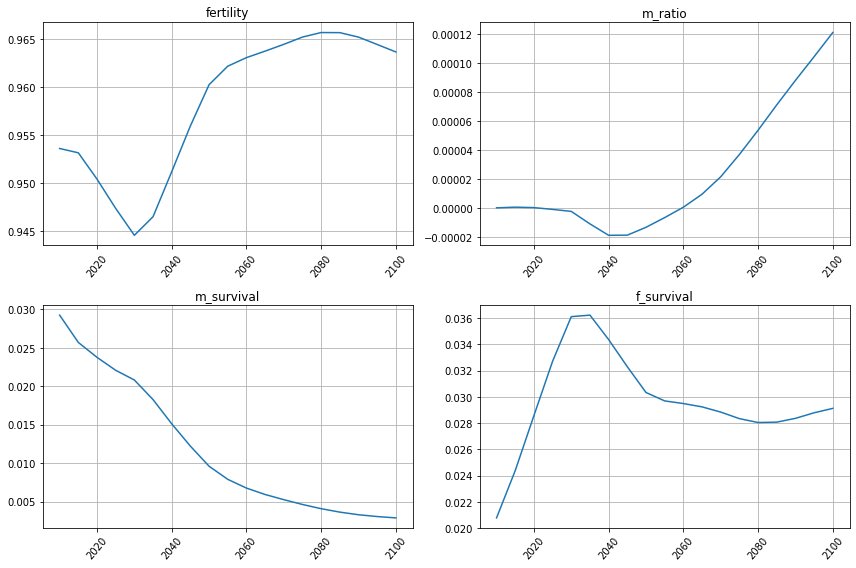

In [14]:
# Графики коэффициентов чувствительности взависимости от предсказания
fig, axs = plt.subplots(2, 2, figsize=(12,8))

plot_names = ['fertility', 'm_ratio', 'm_survival', 'f_survival']
for (i, j), name in zip([(0, 0), (0, 1), (1, 0), (1, 1)], plot_names):
    axs[i][j].plot(forecast_years, [si_s1_4[year][name] for year in forecast_years])

for name, ax in zip(plot_names, axs.flat):
    ax.set(title=str(name))
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(50)

fig.tight_layout()

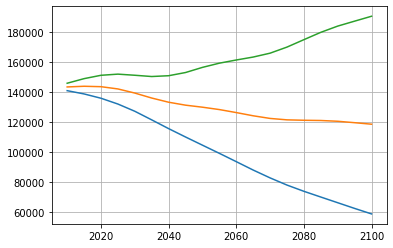

In [15]:
# Интервал между 0.1 и 0.9 квантилями
x = range(2010, 2105, 5)
y_min = [np.quantile(a, 0.1) for a in y.values()]
y_max = [np.quantile(a, 0.9) for a in y.values()]
y_mean = [np.mean(a) for a in y.values()]
plt.plot(x, y_min)
plt.plot(x, y_mean)
plt.plot(x, y_max)
plt.grid(True)
plt.show()

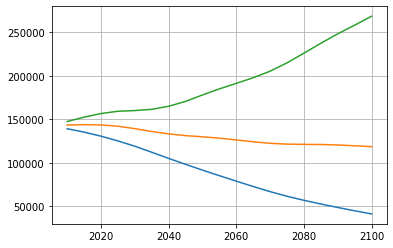

In [16]:
# Интервал между min и max
x = range(2010, 2105, 5)
y_min = [np.quantile(a, 0) for a in y.values()]
y_max = [np.quantile(a, 1) for a in y.values()]
y_mean = [np.mean(a) for a in y.values()]
plt.plot(x, y_min)
plt.plot(x, y_mean)
plt.plot(x, y_max)
plt.grid(True)
plt.show()